In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 1024
nTime = 512 #nLat*2
nSims = 400

phi0 = 1.; m2eff = 1.; lamb = 1.
lenLat = 100.; nCols = 2

nyq = nLat//2+1
spec = nyq

alpha = 8
dx = lenLat/nLat; print(dx)
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

0.09765625


In [4]:
test_sim_location = lambda nT, nL, tem, phi, lam, m2, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_test_classical_solution_with_fluctuations_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'

def test_extract_sim(nT, nL, tem, phi, lam, m2, gam, sim):
    data = np.genfromtxt(test_sim_location(nT, nL, tem, phi, lam, m2, gam, sim))
    return np.asarray([np.reshape(data[:,col], (nT, nL)) for col in range(nCols)])#[:,:129,:]

freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
norm = 1./ phi0 / np.sqrt(2.*lenLat)
omega = freqs**2. + m2eff
spectral_field = lambda tem: np.asarray([norm * np.sqrt(2./(np.exp(omega[k]**0.5/tem) - 1.)) / omega[k]**0.25 if k != nLat//2 else 0 for k in range(nLat)])
th_masses = lambda tem: -m2eff + 0.5 * lamb * np.sum( np.abs(spectral_field(tem))**2. ) / np.sqrt(2)

### Iteratively find stationary domain wall solution

In [5]:
temp = 1
gamma = 0.
all_data = np.asarray([test_extract_sim(nTime, nLat, temp, phi0, lamb, m2eff, gamma, sim) for sim in range(nSims)])

In [6]:
if True:
    div = 10
    fig, ax = plt.subplots(int(np.ceil(nSims/div)), div, figsize = (div*4, 4.*(nSims+1)//div))
    io = -1
    for sim in range(nSims):
        if sim % div == 0: io += 1
        im0 = ax[io][sim%div].imshow(all_data[sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[io][sim%div])
        ax[io][sim%div].set_title('sim = '+str(sim))
    plt.suptitle('T = '+str(temp)+f', $\gamma$ = '+str(gamma), weight=10, size='xx-large', y=1)
    plt.tight_layout(); plt.show()

time : 0 2.3517743207365256 0.039783152238144034 -2.3558258961675604
time : 10 2.3457360418973474 0.049824743953399295 -2.347219301023343
time : 20 2.3738192536256166 0.07396940874877439 -2.37212582782738
time : 30 2.3715370479057643 0.07639189136160275 -2.369802185108537
time : 40 2.346091064689825 0.05117583437004941 -2.347146523632903
time : 50 2.3571220054921818 0.035509024630470835 -2.3606342898575363
time : 60 2.37244747533629 0.032857275485125265 -2.3742279263890707
time : 70 2.3771236960314273 0.03730888425534226 -2.376790932557019
time : 80 2.35515825581236 0.04185783148086902 -2.354839692961701
time : 90 2.3433413722970724 0.03649819774991071 -2.345504711338896
time : 100 2.3642547803891216 0.02853608596118117 -2.3692371570755877
time : 110 2.39192950725869 0.02477704030903371 -2.3963038348090167
time : 120 2.387596362846088 0.024815953591840533 -2.3912178678286846
originally: 2.3517743207365256 0.039783152238144034 -2.3558258961675604
mean : 2.3569469053494063 0.038469927214

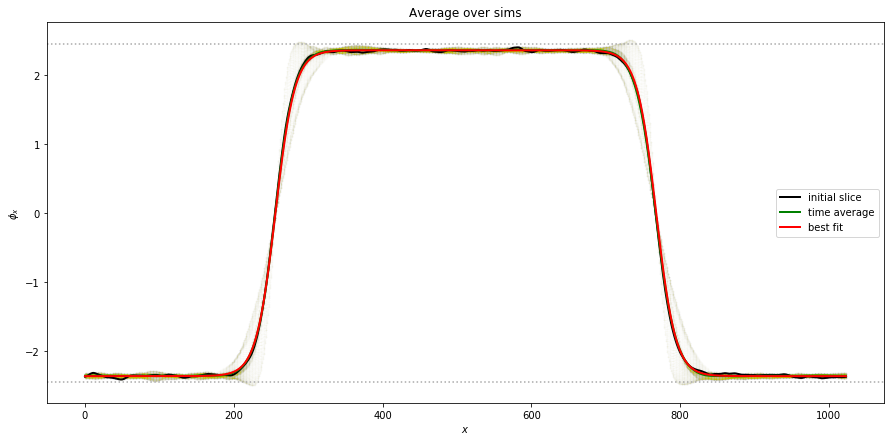

In [7]:
def tanh_fit(x, a1, a2, a3):
    return a1*(np.tanh(a2 * (x-nLat/4.)) - np.tanh(a2*(x-3.*nLat/4.))) + a3

#def tanh_fit(x, a2):
#    a1 = np.sqrt(m2eff*6./lamb)
#    a3 = - np.sqrt(m2eff*6./lamb)
#    return a1*(np.tanh(a2 * (x-nLat/4.)) - np.tanh(a2*(x-3.*nLat/4.))) + a3

list_time = [int(time) for time in range(129)]
list_pos = np.arange(nLat)[::]
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
#if True:
for time in list_time[::]:
    curve = np.mean([all_data[sim][0][time] for sim in range(nSims)], axis=0)[::]
    plt.plot(list_pos, curve, marker = 'o', ms=1, color='y', alpha=0.01, ls='None')
    popt, pcov = scp.optimize.curve_fit(tanh_fit, list_pos, curve)
    if time%10==0: print('time :', time, *popt)

# first slice
curve = np.mean([all_data[sim][0][0] for sim in range(nSims)], axis=0)
plt.plot(list_pos, curve, label='initial slice', linewidth=2, color='k')
popt, pcov = scp.optimize.curve_fit(tanh_fit, list_pos, curve)
print('originally:', *popt)

# mean of all slices
curve = np.mean([np.mean([all_data[sim][0][time] for sim in range(nSims)], axis=0)[::] for time in list_time], axis=0)
plt.plot(list_pos, curve, label='time average', linewidth=2, color='g')

# best fit of mean
popt, pcov = scp.optimize.curve_fit(tanh_fit, list_pos, curve)
plt.plot(list_pos, tanh_fit(list_pos, *popt), label='best fit', linewidth=2, color='r')
print('mean :', *popt)
mean_params = popt
print('cf :', np.sqrt(m2eff*6/lamb))
    
plt.xlabel(f'$x$'); plt.ylabel(f'$\phi_x$')
plt.axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
plt.axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
plt.title('Average over sims'); plt.legend(); plt.show()

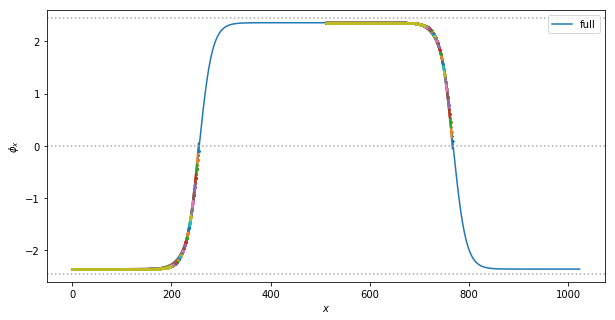

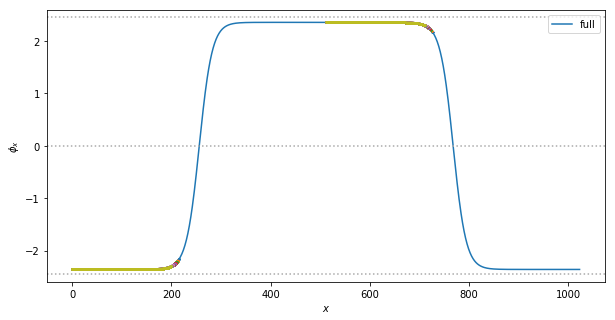

In [8]:
# DSolve[{D[\[CurlyPhi][r],{r,2}]==m2 \[CurlyPhi][r],\[CurlyPhi][0]==-Sqrt[6m2],(\[CurlyPhi]^\[Prime])[0]==0},\[CurlyPhi][r],r]//FullSimplify
def exp_tail_fit(x, a, b, m):
    return a + b * np.exp(x * dx * m)

def exp_tail_fit(x, a, b, m):
    return a + b * m * np.cosh(x * dx * m)


step = 2

list_stops = np.arange(0, 41, 10)
more_storage = []
for STOPFITEARLY in list_stops:
    bool = (True if (STOPFITEARLY == list_stops[0] or STOPFITEARLY == list_stops[-1]) else False)
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    list_pos = np.arange(nLat)
    minx, maxx = min(list_pos), max(list_pos)//2
    curve = tanh_fit(list_pos, *mean_params)
    midindex = curve.tolist().index(curve[(curve<0.01)&(curve>-0.01)][0])

    if bool:
        fig, ax = plt.subplots(1, 1, figsize = (10, 5))
        plt.plot(list_pos, curve, label='full')

    storage = []
    for trunc in np.arange(minx+200, midindex+1 - STOPFITEARLY, step)[::-1]:
        col = next(colors)

        a1 = min(curve)
        tcurve1 = curve[minx:trunc] - a1
        xlist = np.arange(len(tcurve1))
        try:
            popt, pcov = scp.optimize.curve_fit(exp_tail_fit, xlist, tcurve1)
            if bool:
                plt.plot(list_pos[minx:trunc], tcurve1 + a1, 'o', ms=2, color=col)
                plt.plot(list_pos[minx:trunc], exp_tail_fit(xlist, *popt) + a1, color=col, linewidth=2)
            storage.append(popt)
        except:
            continue

        a2 = max(curve)
        tcurve2 = -curve[nLat//2:][minx:trunc] + a2
        xlist = np.arange(len(tcurve2))
        try:
            popt, pcov = scp.optimize.curve_fit(exp_tail_fit, xlist, tcurve2)
            if bool:
                plt.plot(list_pos[nLat//2:][minx:trunc], -tcurve2 + a2, '*', ms=2, color=col)
                plt.plot(list_pos[nLat//2:][minx:trunc], -exp_tail_fit(xlist, *popt) + a2, color=col, linewidth=2)
            storage.append(popt)
        except:
            continue

    if bool:
        plt.axhline(0, color='darkgray', ls=':')
        plt.axhline(np.sqrt(m2eff*6./lamb), color='darkgray', ls=':')
        plt.axhline(-np.sqrt(m2eff*6./lamb), color='darkgray', ls=':')
        plt.xlabel(f'$x$')
        plt.ylabel(f'$\phi_x$')
        plt.legend()
        plt.show()
    more_storage.append(np.asarray(storage))

masses from plateaus 0.9258664524393572 0.9272435249361733
masses from prediction 0.9360641689784439


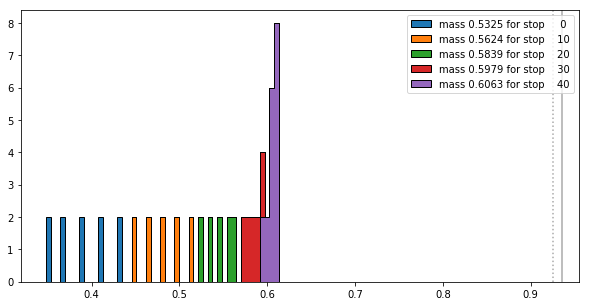

In [26]:
# the deviation comes from extending the possible fits all the way to where the field crosses the metastable point
# i.e. super large deviation from exponential solution
# check param STOPFITEARLY
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
binsave = np.histogram(more_storage[0][:,2]**2., bins=50)[1]
for jj, storage in enumerate(more_storage):
    stop = list_stops[jj]
    plt.hist(storage[:,2]**2., bins=np.linspace(min(binsave), max(binsave), 50), label='mass %5.4f for stop %5.0f'%(np.mean(storage[:,2]**2.), stop), ec='k', histtype='stepfilled')
plt.axvline(mean_params[0]**2.*lamb/6., color='darkgray', ls=':')
print('masses from plateaus', mean_params[0]**2.*lamb/6., mean_params[-1]**2.*lamb/6.)

plt.axvline(np.abs(th_masses(temp)), color='darkgray', ls='-')
print('masses from prediction', np.abs(th_masses(temp)))

plt.legend(); plt.show()